In [ ]:
import pandas as pd
import numpy as np

# 1. Load your 5-year dataset
df = pd.read_csv('/content/drive/MyDrive/gold_AI_model/Xauusd_Dataset.csv')

# 2. Create the 'Next_Close' by shifting the current Close UP by one row
# This aligns "What happened next" with "What we know now"
df['Next_Close'] = df['Close'].shift(-1)

# 3. Create the Directional Target (Binary Classification)
# 1 = Price went UP in the next minute
# 0 = Price went DOWN or stayed the same
df['Target'] = np.where(df['Next_Close'] > df['Close'], 1, 0)

# 4. Cleanup
# Drop the 'Next_Close' helper column so the model doesn't "cheat"
# Drop the last row because we don't know the future of the final candle
df.drop(columns=['Next_Close'], inplace=True)
df.dropna(inplace=True)

# 5. Save the ready-to-train file
df.to_csv('/content/drive/MyDrive/gold_AI_model/Gold_Directional_ML_Dtaset.csv', index=False)

print(f"Success! {len(df)} rows processed. Target is now 1 (UP) or 0 (DOWN).")

Success! 1105432 rows processed. Target is now 1 (UP) or 0 (DOWN).



SECTION 1: RAW PERFORMANCE (ALL DATA)
              precision    recall  f1-score   support

           0       0.50      0.48      0.49    109765
           1       0.51      0.53      0.52    111321

    accuracy                           0.51    221086
   macro avg       0.51      0.51      0.51    221086
weighted avg       0.51      0.51      0.51    221086


SECTION 2: SNIPER METRICS (65% THRESHOLD)
Total High-Confidence Trades: 962
Overall Sniper Accuracy: 55.61%
------------------------------
BUY Precision (Win Rate): 55.69%
BUY Total Signals: 580
SELL Precision (Win Rate): 55.50%
SELL Total Signals: 382


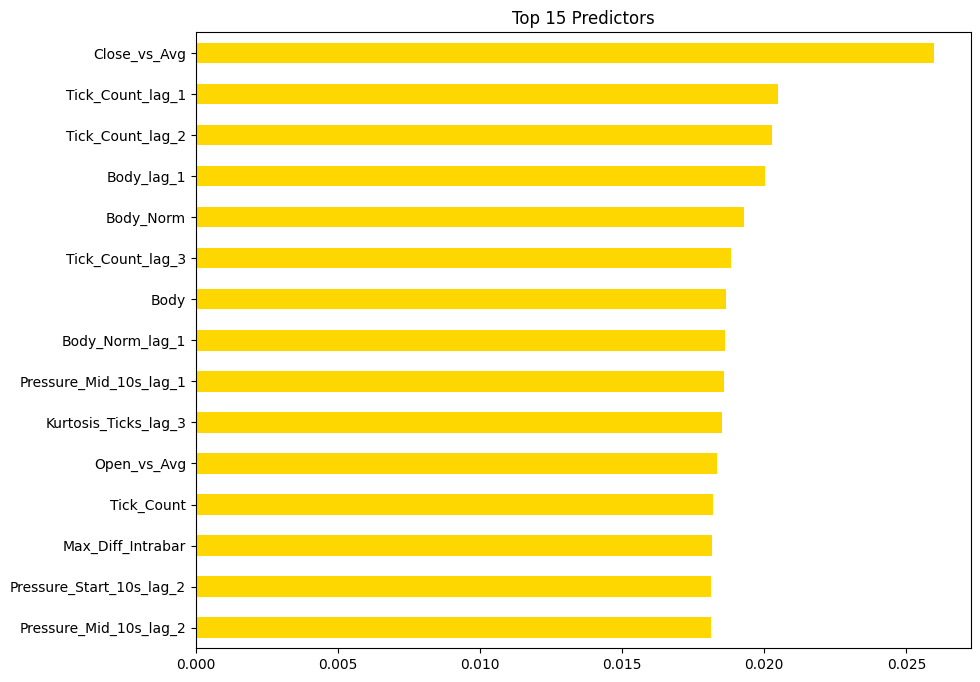

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import zipfile
import os

# --- 1. DATA LOADING ---
file_path = '/content/drive/MyDrive/gold_AI_model/Gold_Directional_ML_Dtaset.csv'
df = pd.read_csv(file_path)

# --- 2. FEATURE ENGINEERING (Lag Testing) ---
df['Target_Binary'] = (df['Close'].shift(-1) > df['Close']).astype(int)

features_to_lag = [
    'Tick_Count', 'Pressure_Start_10s', 'Pressure_Mid_10s', 'Pressure_Last_10s',
    'Relative_Range', 'Close_vs_Avg', 'Open_vs_Avg', 'Max_Diff_Intrabar',
    'Kurtosis_Ticks', 'Skewness_Ticks', 'Body', 'Upper_Shadow',
    'Lower_Shadow', 'Body_Norm', 'Direction'
]

lags = 3 # You mentioned testing 15 lags
for col in features_to_lag:
    for i in range(1, lags + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)

df.dropna(inplace=True)
X = df.drop(columns=['ROW_ID', 'Datetime', 'Target', 'Target_Binary', 'Open', 'High', 'Low', 'Close'])
y = df['Target_Binary']
X, y = X[:-1], y[:-1]

# --- 3. SPLIT & TRAIN ---
split = int(len(X) * 0.80)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# --- 4. SNIPER EVALUATION (The 65% Filter) ---
y_proba = model.predict_proba(X_test)[:, 1]
analysis = pd.DataFrame({'Actual': y_test, 'Prob': y_proba})

# Generate Buy/Sell Labels based on 65% Confidence
analysis['Sniper_Pred'] = np.nan
analysis.loc[analysis['Prob'] > 0.65, 'Sniper_Pred'] = 1
analysis.loc[analysis['Prob'] < 0.35, 'Sniper_Pred'] = 0

# --- 5. DETAILED METRICS SECTION ---
print("\n" + "="*50)
print("SECTION 1: RAW PERFORMANCE (ALL DATA)")
print("="*50)
y_raw_pred = model.predict(X_test)
print(classification_report(y_test, y_raw_pred))

print("\n" + "="*50)
print("SECTION 2: SNIPER METRICS (65% THRESHOLD)")
print("="*50)

# We filter for only the moments where the model took a trade
trades = analysis.dropna(subset=['Sniper_Pred'])

if len(trades) > 0:
    # Manual Precision/Recall for the Sniper
    buy_trades = trades[trades['Sniper_Pred'] == 1]
    sell_trades = trades[trades['Sniper_Pred'] == 0]

    print(f"Total High-Confidence Trades: {len(trades)}")
    print(f"Overall Sniper Accuracy: {(trades['Actual'] == trades['Sniper_Pred']).mean():.2%}")
    print("-" * 30)

    if len(buy_trades) > 0:
        p = precision_score(buy_trades['Actual'], buy_trades['Sniper_Pred'])
        print(f"BUY Precision (Win Rate): {p:.2%}")
        print(f"BUY Total Signals: {len(buy_trades)}")

    if len(sell_trades) > 0:
        # For Sells, we check if Actual was 0 when Pred was 0
        p_sell = (sell_trades['Actual'] == 0).mean()
        print(f"SELL Precision (Win Rate): {p_sell:.2%}")
        print(f"SELL Total Signals: {len(sell_trades)}")
else:
    print("No signals met the 65% confidence criteria.")

# --- 6. VISUALIZATION & SAVE ---
plt.figure(figsize=(10, 8))
pd.Series(model.feature_importances_, index=X.columns).nlargest(15).sort_values().plot(kind='barh', color='gold')
plt.title('Top 15 Predictors')
plt.show()

model_filename = "gold_sniper_v1.json"
model.save_model(model_filename)
with zipfile.ZipFile("/content/drive/MyDrive/gold_AI_model/gold_sniper_v1.zip", 'w') as zipf:
    zipf.write(model_filename)
os.remove(model_filename)

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnx
import zipfile
import os
import shutil

# --- 1. SETUP PATHS ---
zip_path = "/content/drive/MyDrive/gold_AI_model/gold_sniper_v1.zip"
extract_path = "temp_model_extract/"
onnx_path = "/content/drive/MyDrive/gold_AI_model/gold_sniper_v1.onnx"

# --- 2. EXTRACT ---
if os.path.exists(extract_path): shutil.rmtree(extract_path)
os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

model_file = [f for f in os.listdir(extract_path) if f.endswith('.json')][0]
full_model_path = os.path.join(extract_path, model_file)

# --- 3. LOAD & FIX FEATURE NAMES ---
print(f"🧠 Loading Booster and patching feature names...")
booster = xgb.Booster()
booster.load_model(full_model_path)

# THE FIX: Force the booster to use 'f0', 'f1', etc.
num_features = 60 # (15 features * 3 lags + 15 original)
booster.feature_names = [f"f{i}" for i in range(num_features)]

# --- 4. CONVERT TO ONNX ---
print("🔄 Converting to ONNX...")
initial_type = [('input', FloatTensorType([None, num_features]))]

# Note: We pass the booster directly
onnx_model = onnxmltools.convert_xgboost(
    booster,
    initial_types=initial_type,
    target_opset=13
)

# --- 5. VALIDATE & SAVE ---
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

try:
    onnx.checker.check_model(onnx.load(onnx_path))
    print("\n" + "="*40)
    print("💎 SUCCESS! The GOLD SNIPER is now 100% VALID!")
    print(f"File saved at: {onnx_path}")
    print("="*40)
except Exception as e:
    print(f"❌ Structural Error: {e}")

shutil.rmtree(extract_path)

🧠 Loading Booster and patching feature names...
🔄 Converting to ONNX...

💎 SUCCESS! The GOLD SNIPER is now 100% VALID!
File saved at: /content/drive/MyDrive/gold_AI_model/gold_sniper_v1.onnx


In [25]:
import onnx
import os

# 1. Direct path to your .onnx file
model_path = '/content/drive/MyDrive/gold_AI_model/gold_sniper_v1.onnx'

# 2. Check if the file exists before loading
if os.path.exists(model_path):
    # Load and inspect the model
    model = onnx.load(model_path)
    print(f"--- Model: {os.path.basename(model_path)} ---")

    # Inspect Inputs
    for input in model.graph.input:
        # Get dimensions; handle cases where dim might be a variable (None/0)
        dims = [d.dim_value if d.dim_value > 0 else "None" for d in input.type.tensor_type.shape.dim]
        print(f"Input Name: {input.name} | Expected Shape: {dims}")

    # Inspect Outputs
    for output in model.graph.output:
        dims = [d.dim_value if d.dim_value > 0 else "None" for d in output.type.tensor_type.shape.dim]
        print(f"Output Name: {output.name} | Expected Shape: {dims}")
else:
    print(f"❌ Error: File not found at {model_path}. Please check the path in your Google Drive.")

--- Model: gold_sniper_v1.onnx ---
Input Name: input | Expected Shape: ['None', 60]
Output Name: label | Expected Shape: ['None']
Output Name: probabilities | Expected Shape: ['None', 2]
